In [7]:
import numpy as np
import scipy.signal as scipysig
from typing import Tuple
from pyzonotope import MatrixZonotope, Zonotope, concatenate_zonotope
from pydatadrivenreachability import compute_LTI_matrix_zonotope
import scipy.stats as scipystats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Patch
import matplotlib.pyplot as plt


np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
A = np.array([[0.7]])
B = np.array([[0.5]])

dim_x = 1
dim_u = 1


def collect_data(steps: int, std_u: float, std_w: float) -> Tuple[np.ndarray, np.ndarray]:
    U = np.zeros((dim_u, steps))
    X = np.zeros((dim_x, steps + 1))

    X[:, 0] = np.random.normal(size=(dim_x))

    for i in range(steps):
        U[:, i] = std_u * np.random.normal(size=(dim_u))
        X[:, i+1] = A @ X[:, i] +  np.squeeze(B * U[:, i]) + std_w * np.random.normal(size=(dim_x))

    return X.T, U.T

[[0.648 0.539]]
[[0.576 0.212]]


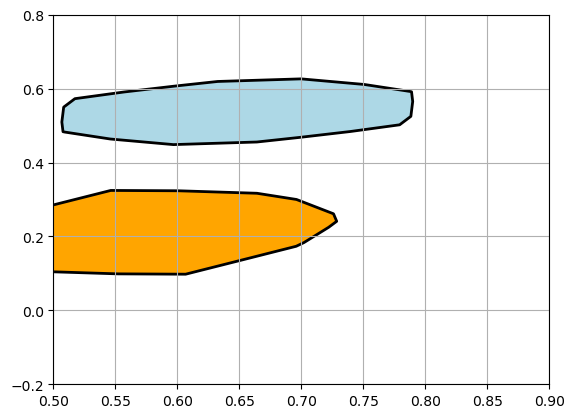

In [68]:
std_w = 1e-1
std_u = 1
samples = 10

W = Zonotope([0], [[std_w]])
X, U = collect_data(samples, std_u, std_w)
Mw = concatenate_zonotope(W, samples)

Msigma: MatrixZonotope = compute_LTI_matrix_zonotope(X[:-1], X[1:], U, Mw)

AttackU = std_u * np.random.normal(size=U.shape)
Msigma_poisoned: MatrixZonotope = compute_LTI_matrix_zonotope(X[:-1], X[1:], AttackU, Mw)
Mz = Msigma.zonotope.reduce(5)

print(Msigma.center)
print(Msigma_poisoned.center)
Mz_poisoned = Msigma_poisoned.zonotope.reduce(5)


fig, ax = plt.subplots()

collection1 = PatchCollection([Mz.polygon],  facecolor='lightblue', edgecolor='black', lw=2, label='Original data')
collection2 = PatchCollection([Mz_poisoned.polygon],  facecolor='orange', edgecolor='black', lw=2, label='Poisoned data')

ax.add_collection(collection1)
ax.add_collection(collection2)
plt.xlim(0.5, 0.9)
plt.ylim(-0.2, 0.8)
# plt.xlabel(r'$a$')
# plt.ylabel(r'$b$')
# plt.title(f'Identification of $(a,b)$ - {samples} samples')
#plt.legend(handles = [Patch(color='lightblue', label='Original data'), Patch(color='orange', label='Poisoned data')] )
plt.grid()
plt.show()




In [69]:
AB = X[1:].T @ np.linalg.pinv(np.vstack([X[:-1].T, U.T]))
AB_noU = X[1:].T @ np.linalg.pinv(X[:-1].T)
AB_poisoned = X[1:].T @ np.linalg.pinv(np.vstack([X[:-1].T, AttackU.T]))

In [70]:
Y1 = AB_noU @ X[:-1].T
Y2 = AB_poisoned @ np.vstack([X[:-1].T, AttackU.T])


Bhat = AB_poisoned[:,1]
P = np.vstack([X[:-1].T, AttackU.T]) @ np.vstack([X[:-1].T, AttackU.T]).T
k =1 
Pinv = np.linalg.inv(P[-k:,-k:]) / k
ms= np.power(X[1:] - Y2.T, 2).sum() / (X.shape[0] -1 -1 -2)
F = Bhat.T @ Pinv @ Bhat/ms
print(Bhat.T @ Pinv @ Bhat * k)
print(1-scipystats.f.cdf(F, k, X.shape[0] - 1 - 2))
R1 = np.power(X[1:] - Y1.T, 2).sum()
R2 = np.power(X[1:] - Y2.T, 2).sum()
F = ((R1-R2) / (1))/( R2 / (X.shape[0]-1- 2))
print(R1-R2)
print(F)
1-scipystats.f.cdf(F, 1, X.shape[0] - 1 - 2)


0.007703622680763826
0.8892279903347008
0.2519500887932158
0.7727241195613206


0.4050045484461384

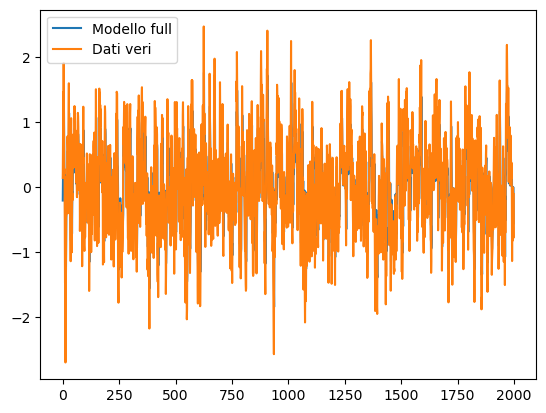

In [106]:
import matplotlib.pyplot as plt
plt.plot(Y2.T, label='Modello full')
plt.plot(X[1:], label='Dati veri')
#plt.plot(Y1.T, label='Modello ridotto')
plt.legend()
plt.show()

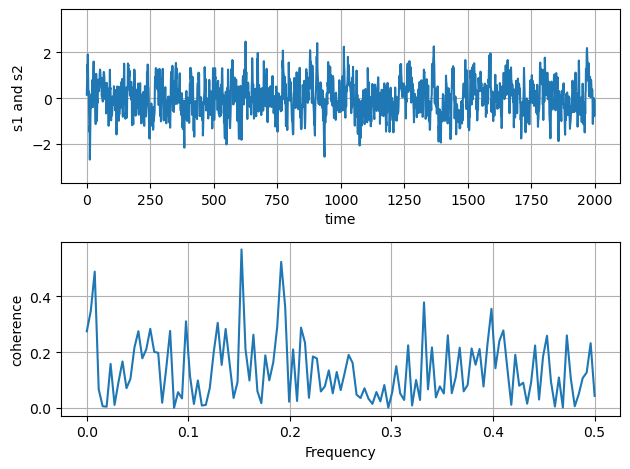

In [107]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(AttackU.T)
axs[0].plot(X[1:])
axs[0].set_xlabel('time')
axs[0].set_ylabel('s1 and s2')
axs[0].grid(True)

cxy, f = axs[1].cohere(AttackU[:,0], X[1:,0], 256, 1. / 1)
axs[1].set_ylabel('coherence')

fig.tight_layout()
plt.show()

In [52]:
R2

5633.832896086318